## Обучение модели для сечения YZ

### Настройки и параметры

Параметры:
* alpha = 0.7
* beta  = 0.3
* dropout = 0.3

In [1]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/t')
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/MyDrive/t'

In [2]:
pip install simpleitk

In [3]:
pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 3.8MB 44.6MB/s 
     |████████████████████████████████| 450kB 50.6MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cb4b4997705fffc9dcf579a21275ec77c7c135ff8feca79a791dfc39545e48f9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorflow-estimator<2.5.0,>=2.4.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installa

In [4]:
import os
import numpy as np
from numpy.random import shuffle, seed
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pandas as pd
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalCrossentropy as cce, MeanIoU

from modules import *
from unet_keras.unet import load_2d_unet 

In [5]:
# config

source_folder = 'source_data'
dataset_folder = 'dataset'

n_input_channels      = 1                 # number of source image layers
n_output_channels     = 20                # number of segmentation classes
z_dim                 = 128               # required image dimension in Z plane

trainval_files        = [2,3,4,5,6,7]     # filenames for train and validation
predict_file          = [1]               # filename for testing

threshold             = 0.3               # segmentation 0...1 threshold  
plane                 = 'YZ'              # prediction plane

n_epochs              = 300
batch_size            = 32
lr                    = 1e-3

### Загрузка данных

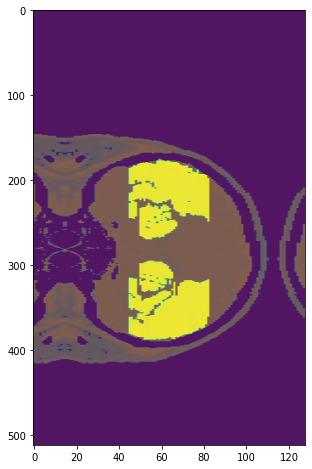

In [6]:
X = load_pkl(os.path.join(dataset_folder, plane+'_X.pkl'))
y = load_pkl(os.path.join(dataset_folder, plane+'_y1.pkl'))
y2 = load_pkl(os.path.join(dataset_folder, plane+'_y2.pkl'))
y = np.vstack((y, y2))
del y2

# roughly check if the X-y arrays are correct
sample_n = 200
plt.figure(figsize=(16,8))
plt.imshow(X[sample_n,:,:,0],alpha=0.8, aspect=.4),plt.imshow(np.sum(y[sample_n,:,:,:],axis=2),alpha=0.6, aspect=.4)
plt.show()

In [7]:
all_indices = np.arange(X.shape[0])
seed(42)
shuffle(all_indices)

trainval_split=.8

n_indices = len(all_indices)
train_part = int(n_indices*trainval_split)
train_indices = all_indices[:train_part]
val_indices = all_indices[train_part:]
len(train_indices), len(val_indices)

(2457, 615)

### Обучение

In [8]:
model = load_2d_unet(input_shape=X.shape[1:], num_labels=20, noise=0.0, dropout=0.3, init_filter=32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 128, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 512, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 128, 32) 320         gaussian_noise[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 128, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
model.compile(optimizer=Adam(learning_rate=lr), loss=tversky_loss, metrics=[cce(), 'mse'])

# data generators
train_generator = BatchGenerator(X, y, train_indices, batch_size=batch_size)
val_generator   = BatchGenerator(X, y, val_indices, batch_size=batch_size)

# callbacks
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True, verbose=1)
lr_reduce  = ReduceLROnPlateau(monitor='loss', min_lr=0, cooldown=3, factor=0.1, patience=3, verbose=1, mode='min')
m_save = ModelCheckpoint(str(Path(os.getcwd(), plane+'_a7b3d3_temp_weights_cl.h5')), monitor='loss', 
                         verbose=0, save_best_only=True, save_weights_only=True, mode='min', period=1)

# train model
history = model.fit_generator(generator=train_generator, validation_data=val_generator, 
                             epochs=n_epochs, callbacks=[early_stop, lr_reduce, m_save],                              
                             verbose=1, workers=0, use_multiprocessing=False)

model.save_weights(str(Path(os.getcwd(),plane+'_a7b3d3_weights_cl.h5')))
print('Done.')
print("Val_loss: %2.4e" % np.min(history.history['val_loss']))

Epoch 1/300
76/76 [==============================] - 112s 1s/step - loss: 19.8322 - categorical_crossentropy: 0.1010 - mse: 0.1701 - val_loss: 19.9507 - val_categorical_crossentropy: 0.1406 - val_mse: 0.4162
Epoch 2/300
76/76 [==============================] - 101s 1s/step - loss: 19.2863 - categorical_crossentropy: 0.0945 - mse: 0.0618 - val_loss: 19.8688 - val_categorical_crossentropy: 0.1866 - val_mse: 0.3489
Epoch 3/300
76/76 [==============================] - 104s 1s/step - loss: 15.5326 - categorical_crossentropy: 0.0831 - mse: 0.0129 - val_loss: 19.3934 - val_categorical_crossentropy: 0.4449 - val_mse: 0.0309
Epoch 4/300
76/76 [==============================] - 127s 2s/step - loss: 10.4986 - categorical_crossentropy: 0.0650 - mse: 0.0028 - val_loss: 15.0525 - val_categorical_crossentropy: 0.1556 - val_mse: 0.0047
Epoch 5/300
76/76 [==============================] - 101s 1s/step - loss: 7.1975 - categorical_crossentropy: 0.0338 - mse: 8.6923e-04 - val_loss: 8.7828 - val_categoric

### Результаты

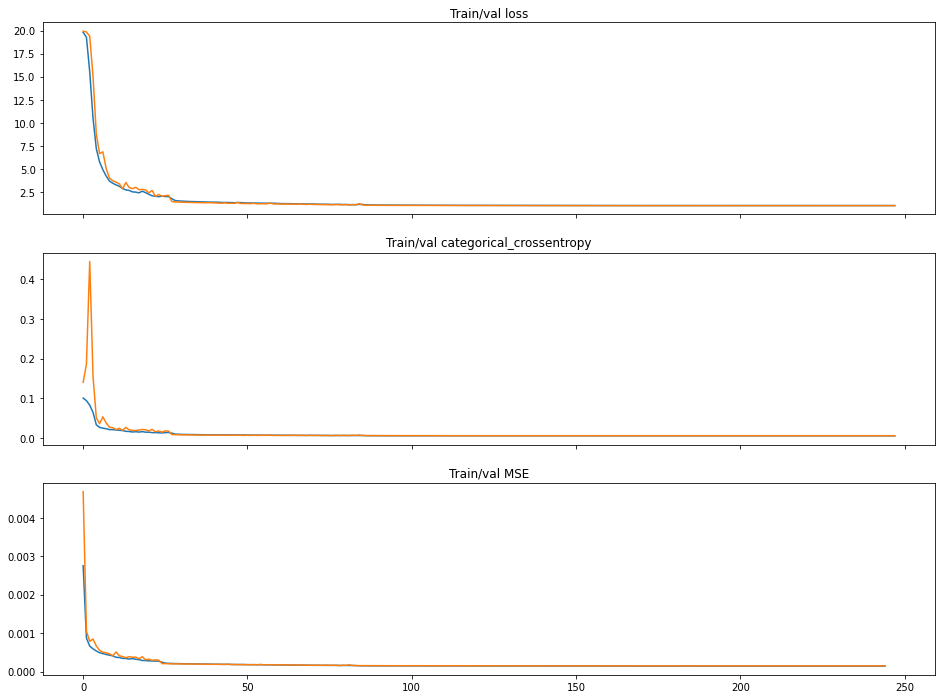

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16,12), sharex=True)
ax1.set_title('Train/val loss')
ax1.plot(history.history['loss']), ax1.plot(history.history['val_loss']);
ax2.set_title('Train/val categorical_crossentropy')
ax2.plot(history.history['categorical_crossentropy']), ax2.plot(history.history['val_categorical_crossentropy']);
ax3.set_title('Train/val MSE')
ax3.plot(history.history['mse'][3:]), ax3.plot(history.history['val_mse'][3:]);

In [11]:
save_pkl(history.history, os.path.join(plane+'_a7b3d3_history_cl.pkl'))